# Stage 2 - Attribute Analysis
## Step 0: Import Required Packages
Below is a list of the python packages we used while preforming Stage 2 of the project.

In [1]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import json
import pandas as pd
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Load & Prepare Data
In this step we will __load__ our data into the python notebook and __manipulate__ the data so that it is in a format that is appropriate in order to analyze each attribute.

__Step 1.1:__ Select Table to Analyze &  Load Table from Github

In [2]:
# Links to .CSV tables on Github
table_spoj = "https://raw.githubusercontent.com/KaranTalreja\
/CS638/master/spoj/json/problems.csv?token=AKuoLQ5TaJyvWHVY8M\
6_6MbudhCVoTPrks5YFpVIwA%3D%3D"
table_codechef = "https://raw.githubusercontent.com/KaranTalre\
ja/CS638/master/codechef/data/codechef_problems.csv?token=AKuo\
LShPnf70FONGdoBnqcJ48j9uYA8bks5YCnDKwA%3D%3D"

# Choose table to analyze
choose_table_A = table_spoj

# Load table to Pandas dataframe
table_A = pd.read_csv(urlopen(choose_table_A))

__Step 1.2:__ Manipulate Table Format & Select 10 Attributes

In [3]:
# Convert "TimeLimit" from string to float
def str_to_float(df):
    times = str(df["time_limit"]).replace("s","").split("-")
    try:
        return pd.Series([times[0], times[1]])
    except:
        return pd.Series([times[0], times[0]])

table_A[["lower_time_limit", "upper_time_limit"]] = \
table_A.apply(str_to_float, axis=1)


# "DateAdded" attribute as type datetime
def str_to_datetime(df):
    try:
        return datetime.strptime(df["date_added"], "%Y-%m-%d")
    except:
        pass

table_A["date_added"] = table_A.apply(str_to_datetime, axis=1)

__Step 1.3:__ Select 10 Attributes

In [4]:
table_A = table_A[["title", "added_by", "description", "input",
                   "output", "upper_time_limit", "accuracy",
                   "solved_by", "tags", "implementation_difficulty",
                   "concept_difficulty"]]

def tags_missing(df):
    if df["tags"] == "0":
        return None
    else:
        return df["tags"]

table_A["tags"] = table_A.apply(tags_missing, axis=1)

table_A["difficulty"] = table_A["implementation_difficulty"] + \
table_A["concept_difficulty"]

## Bin difficulty based on percentile (beginner, easy, medium, 
## hard, challenge, N/A) Next stage...
table_A = table_A.drop(["implementation_difficulty", 
                        "concept_difficulty"], axis=1)
table_A.head(3)

,title,added_by,description,input,output,upper_time_limit,accuracy,solved_by,tags,difficulty
0,"TEST - Life, the Universe, and Everything",mima,Your program is to use the brute-force appro...,NaN,NaN,10,32.93,100118,"88,4,89",5.0
1,CMEXPR - Complicated Expressions,adrian,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,5,26.55,655,None,26.0
2,BABTWR - Tower of Babylon,Micha Czuczman,Apart from the Hanging Gardens the Babylonia...,The number of types of blocks n is located i...,For each test case your program should outpu...,3,49.68,2087,None,36.0


## Step 3: Begin Analyzing Attributes
1. Count Missing Values
2. Discuss Missing Values Fill
3. Classify Attribute as:
    1. Numeric
    2. Textual
        1. If textual, report the average, minimal and maximal lengths of its values (length is measured in the number of characters in the value).
    3. Categorical
    4. Boolean
4. Find and report possible outliers and anomalies among the attribute values
5. Search for possible synonyms
6. Are attribute values "sprinkled" over other attributes?
7. Note any other data quality issues

### Attribute Analysis - Helper Functions

In [5]:
def missing_value_count(table, attribute):
    missing_values = 0
    for attr in table[attribute]:
        if pd.isnull(attr):
            missing_values += 1
        else:
            pass
    
    attr_length = len(table)
    percent_missing = float(missing_values)/float(attr_length)

    return "%s:%d missing values. (%.2f percent or %d/%d)" % \
(attribute, missing_values, percent_missing*100., missing_values, attr_length)

def len_nan(x):
    try:
        return len(x)
    except:
        return 0
    
def myround(x, base):
    return int(base * round(float(x)/base))
    
def textual_summary(table, attribute):
    char_len = table[attribute].apply(len_nan)
    return "%s: mean length = %.2f min length = %d max length = %d" % \
(attribute, char_len.mean(), char_len.min(), char_len.max())
    
def textual_histogram(table, attribute, range=[0,0], stdev=3, bins=20):
    char_len = table[attribute].apply(len_nan)
    if range == [0,0]:
        range = [0, myround(char_len.std()*stdev, 5)]
    plt.hist(char_len, bins=bins, range=range)
    plt.title("%s - Character Count Distribution (%d bins)" % \
              (attribute, bins))
    plt.show()
    summary_table = pd.DataFrame()
    summary_table["outliers"] = table[attribute][char_len[
            ((char_len - char_len.mean()) / char_len.std()).abs() > stdev
            ].index]
    summary_table["out_len"] = table[attribute][char_len[
            ((char_len - char_len.mean()) / char_len.std()).abs() > stdev
            ].index].apply(len_nan)
    print "There are %d outliers outside of %d standard \
    deviations of %s." % (len(summary_table), stdev, attribute)
    return summary_table.sort_values(by="out_len")

def numeric_histogram(table, attribute, range=[0,0], stdev=3, bins=20):
    values = table[attribute].astype(float)
    if range == [0,0]:
        range = [0, myround(values.std()*stdev, 5)]
    plt.hist(values, bins=bins, range=range)
    plt.title("%s - Histogram (%d bins)" % (attribute, bins))
    plt.show()
    summary_table = pd.DataFrame()
    summary_table["outliers"] = table[attribute][values[
            ((values - values.mean()) / values.std()).abs() > stdev
        ].index].astype(float)
    print "There are %d outliers outside of %d standard \
    deviations of %s." % (len(summary_table), stdev, attribute)
    return summary_table.sort_values(by="outliers")

# Step 1: Missing Values

In [6]:
for attribute in table_A.columns.values:
    print missing_value_count(table_A, attribute)

title:0 missing values. (0.00 percent or 0/5166)
added_by:12 missing values. (0.23 percent or 12/5166)
description:0 missing values. (0.00 percent or 0/5166)
input:753 missing values. (14.58 percent or 753/5166)
output:876 missing values. (16.96 percent or 876/5166)
upper_time_limit:0 missing values. (0.00 percent or 0/5166)
accuracy:0 missing values. (0.00 percent or 0/5166)
solved_by:0 missing values. (0.00 percent or 0/5166)
tags:4173 missing values. (80.78 percent or 4173/5166)
difficulty:2984 missing values. (57.76 percent or 2984/5166)


# Step 2: Fill Missing Values
* __title:__ There are no missing values for this attribute.
* __added_by:__ This attribute states the user account responsible for posting the problem, so there does not seem to be a good way to fill this value. Since there are only 12 missing values out of 5166, we will just leave the value as null.
* __description:__ There are no missing values for this attribute.
* __input:__ This value has 14.58% of the values missing but most of these missing values are sprinkled in the description so we will have to parse that variable to fill these missing values.
* __output:__ This value has 16.96% of the values missing but most of these missing values are sprinkled in the description so we will have to parse that variable to fill these missing values.
* __upper_time_limit:__ There are no missing values for this attribute.
* __accuracy:__ There are no missing values for this attribute.
* __solved_by:__ There are no missing values for this attribute.
* __tags:__ For the instances without tags, we could look into pulling key words from the description and title. Both the title and description would contain the main ideas of the problem which is the point of this variable.
* __difficulty:__ The difficulty has a large percentage of missing values (57.76%), so in order to fill some of these values, we could use a machine learning model to estimate the difficulty based on each instance's accuracy, upper_time_limit, and tags.

# Step 3: Classify the Attribute
* __title:__ textual
* __added_by:__ categorical (there is a limited list of users who can submit problems so each problem can be categorized into one of the users)
* __description:__ textual
* __input:__ textual
* __output:__ textual
* __upper_time_limit:__ numeric
* __accuracy:__ numeric
* __solved_by:__ numeric
* __tags:__ categorical (there is a list of keys that can be assigned to a problem)
* __difficulty:__ numeric

# Step 4: Textual Variables - Summary

In [7]:
for attribute in ["title", "description", "input", "output"]:
    print textual_summary(table_A, attribute)

title: mean length = 25.40 min length = 9 max length = 61
description: mean length = 1039.23 min length = 1 max length = 10969
input: mean length = 283.58 min length = 0 max length = 3411
output: mean length = 348.57 min length = 0 max length = 63965


# Step 5: Outliers & Anomalies
__title:__
* The title attribute is approximately normally distributed with a long tail to the right. There are a 13 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

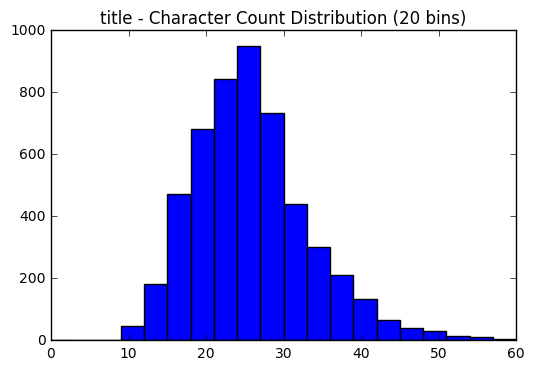

There are 13 outliers outside of 4 standard     deviations of title.


,outliers,out_len
611,NITT1 - My Reaction when there is no internet ...,56
1229,"BUGTEST - Tutorial for ""Your Rank is Pure (EXT...",56
2736,EMAILGEN - Generador de direcciones de correo ...,56
2945,PES16SEQ - Search for an integer using sequent...,56
2968,PES16TSP - Solution for a Travelling Salespers...,56
1900,VAL_GAM4 - Happy Valentine Day (Valentine Adve...,57
3130,GUESSBDAY - Guess the birthday of author or th...,57
2975,PES16SO3 - Sort an array of student records by...,58
1025,IRECSQRT - Inverse of Recurrence Problem With ...,59
2592,PESADA08 - Position of all-distinct-digits num...,59


In [8]:
textual_histogram(table_A, "title", range=[0,60], stdev=4)

__added_by:__
* The number of posts by user seem to decline at a regular rate with the exception of "Fudan University Problem Setters". This seems to be the only outlier for this attribute.

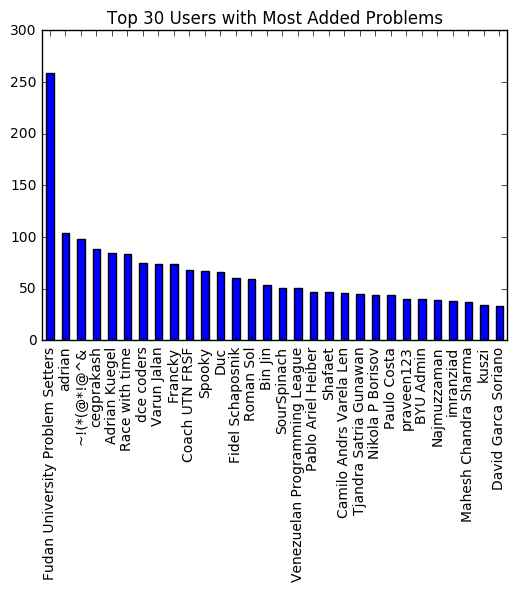

In [9]:
table_A['added_by'].value_counts()[:30].plot(kind='bar')
plt.title("Top 30 Users with Most Added Problems")
plt.show()

__description:__
* The description attribute seems to follow a log normal distribution. There are a 40 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

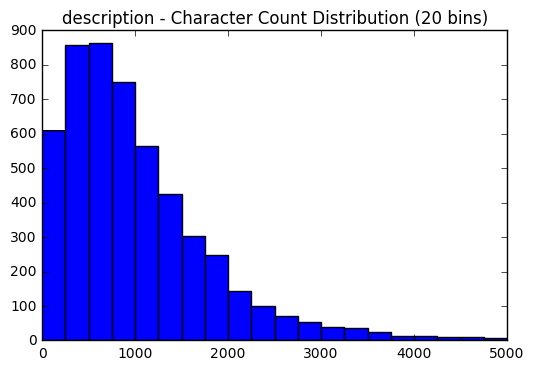

There are 40 outliers outside of 4 standard     deviations of description.


,outliers,out_len
5164,"For years, a group of Regional Contest Dir...",4593
142,People in Nloglnia are very addicted to vide...,4603
764,"'""For I am Saruman the Wise, Saruman Ring-...",4619
1821,With growing popularity of Robert in Harvard...,4642
4908,Most nonfiction and reference books have an ...,4677
1763,Charlie and the Chocolate Factory Charlie...,4714
4814,Deoxyribonucleic acid (DNA) is composed of a...,4734
67,Harry's friend Charlie Weasley has partner...,4796
768,Wormtongue looked from face to face. In hi...,4867
2298,All of us are familiar with the reign of t...,4889


In [10]:
textual_histogram(table_A, "description", 
                  range=[0,5000], stdev=4)

__input:__
* The input attribute seems to follow an exponential distribution. There are a 36 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

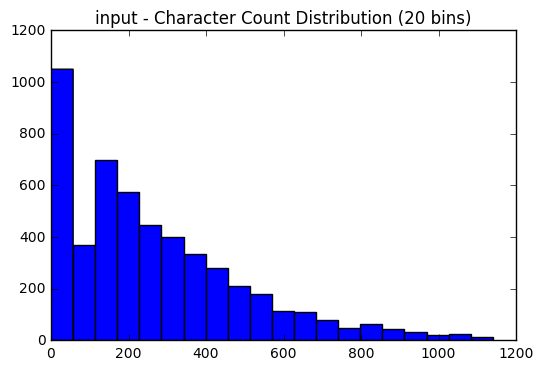

There are 36 outliers outside of 4 standard     deviations of input.


,outliers,out_len
1780,The number of equations t is in the first li...,1426
489,"The input consists of multiple datasets, eac...",1426
3845,The first line of the standard input contain...,1432
3748,The first line of the input contains a singl...,1436
868,The first line of the input contains a numbe...,1445
3119,The first line of input contains two integer...,1446
128,The first line contains a number T ( T 100)...,1458
3696,"The input consists of multiple datasets, eac...",1488
2555,The input file contains one or more test cas...,1495
4956,The graph to be read comes in several lines:...,1498


In [11]:
textual_histogram(table_A, "input", stdev=4)

__output:__
* The output attribute seems to follow an exponential distribution. There are a 13 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

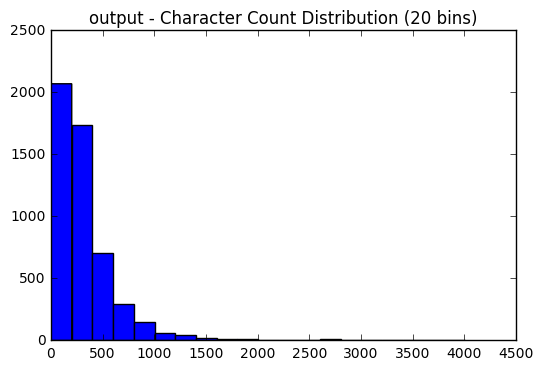

There are 13 outliers outside of 4 standard     deviations of output.


,outliers,out_len
749,"For each dialogue, your program must output ...",4778
668,"For each input case you must print ""Scenario...",4887
1973,Your output should describe the strategy you...,5117
2485,For each game you have to print the sequence...,5291
2493,For every testcase you have to generate a co...,5453
1051,For each test case you must output a picture...,5833
1638,For each of the test cases output the reques...,6801
1642,For each of the test cases output the reques...,6801
1643,For each of the test cases output the reques...,6801
3024,Output the value of <strong>F(x)</strong> E...,8232


In [12]:
textual_histogram(table_A, "output", stdev=4)

__upper_time_limit:__
* The upper_time_limit attribute seems to (sort of) follow an exponential distribution. There are a 45 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

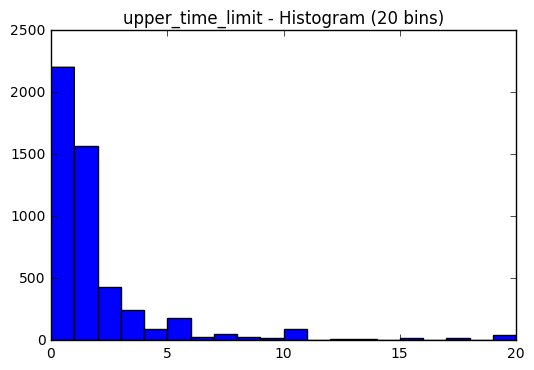

There are 45 outliers outside of 4 standard     deviations of upper_time_limit.


,outliers
3200,32.00
3575,32.00
4082,32.12
35,34.61
2852,35.00
1494,36.00
4385,37.47
637,40.00
3586,40.00
721,44.00


In [13]:
numeric_histogram(table_A, "upper_time_limit", 
                  range=[0,20], stdev=4)

__accuracy:__
* The accuracy attribute does not strictly follow any distributions but there seems to be a normal distribution around 30 with an additional increase as the values approach 100. There are no major outliers in this set.

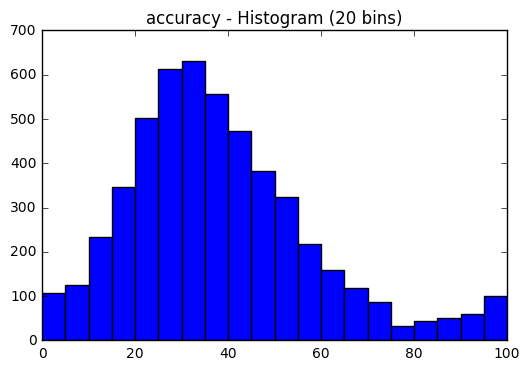

There are 0 outliers outside of 4 standard     deviations of accuracy.


,outliers


In [14]:
numeric_histogram(table_A, "accuracy", 
                  range=[0,100], stdev=4)

__solved_by:__
* The solved_by attribute seems to follow an exponential distribution. There are a 30 instances that have title character lengths longer than 4 times the standard deviation for this attribute.

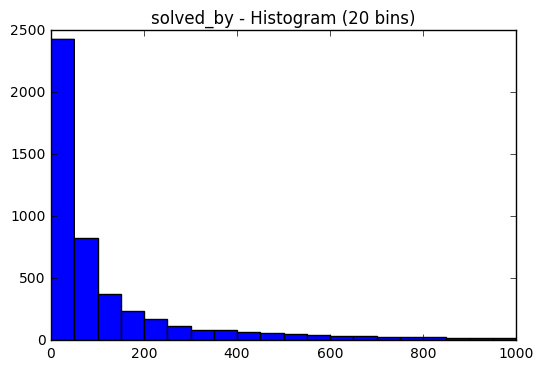

There are 30 outliers outside of 4 standard     deviations of solved_by.


,outliers
3159,8340.0
3619,8472.0
3392,8751.0
3487,8797.0
5148,9103.0
3618,9144.0
2363,9164.0
4441,10047.0
3694,10101.0
4910,10274.0


In [15]:
numeric_histogram(table_A, "solved_by", range=[0, 1000], stdev=4)

__tags:__
* For the tags attribute, tags 1, 4, 7, 16, 6, & 10 appear to be relative outliers as they are tagged in the most problems with a drop off of at least 20 between each of these and the next most common tag. 

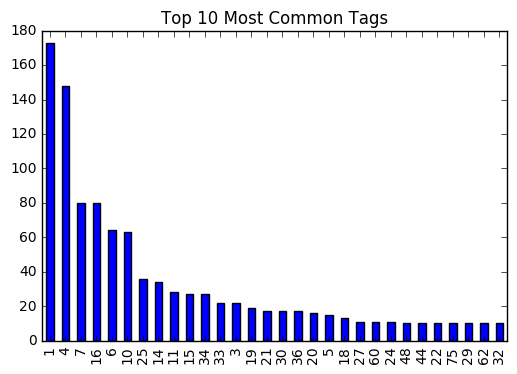

In [16]:
def all_tag_counts(table):
    try:
        return table["tags"].split(",")
    except:
        pass
    
tag_list = []

for instance in table_A.apply(all_tag_counts, axis=1):
    if instance != None:
        for tag in instance:
            tag_list.append(tag)
    else:
        pass

tag_list = pd.Series(tag_list)

tag_list.value_counts()[:30].plot(kind='bar')
plt.title("Top 10 Most Common Tags")
plt.show()

__difficulty:__
* The difficulty attribute does not seem to follow a strict distribution but since it all values range from 0 to 100, we would not consider any values outliers for this attribute

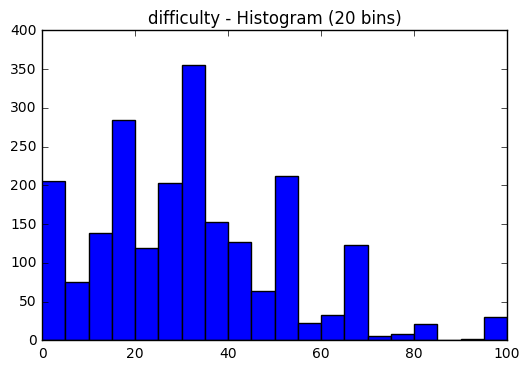

There are 0 outliers outside of 4 standard     deviations of difficulty.


,outliers


In [17]:
numeric_histogram(table_A, "difficulty", 
                  range=[0,100], stdev=4)

# Step 6: Format Standardization
* __title:__ All values are textual. This is also the problem's unique identifier, so we must be sure that none of these are the same (they are all unique).
* __added_by:__ There are no specific criteria with this attribute.
* __description, input, & output:__ These attributes are free-form text so there are no major formatting concerns other than that the input and output should not be included in the description. If they are, the description must be parsed to move the input and output to their respectives attribute locations.
* __upper_time_limit:__ All values in this are numeric, so there are no concerns with this attribute's format.
* __accuracy:__ All values in this are numeric, so there are no concerns with this attribute's format.
* __solved_by:__ All values in this are numeric, so there are no concerns with this attribute's format.
* __tags:__ Many instances have no associated tags, but those that do may have more than one so this attribute is technically a list of categories. As a result, we must be able to parse this during matching and analysis.
* __difficulty:__ All values in this are numeric, so there are no concerns with this attribute's format.

# Step 7: Synomyms
* The only attribute that may contain synomyms is the __tags__ attribute where multiple tags could essentially have the same meaning. We will have to investigate this before preforming any matching or analysis tasks.

# Step 8: Sprinkled Values
* The most notable area of concern related to sprinkled values appears between the __description__, __input__, and __output__ attributes. As previously stated, the description often contains the values that should be listed under the input and output attributes, so we will have to parse these attributes out before preforming any matching or analysis tasks.

# Step 9: Other Data Quality Concerns
* At this point, we do not have any other major data quality concerns. 